# INFO8010: Homework 2

In the previous homework, you learned how to program your first neural network starting from the very first principles of deep learning. If you managed to solve last assignment without any problems **congratulations!** If that was not the case **don't worry**, here's a second assignment for you which you can use to get better at deep learning.

In this homework we will see some slighly more complicated deep learning concepts: we will start by taking a look at some of PyTorch's functionalities that are necessary for training deep networks efficiently. We will then train our first neural networks for tackling different image classification tasks, learn to build custom datasets and explore how to train a CNN.  

The strucutre of the notebook is identical to the one of the previous homework. Similarly to last time, you have to submit the notebook **with your solutions** to the exercises. When you encounter a `# your code` comment, you have to write some code yourself and you have to discuss the code/results when you see the instruction

> your discussion

Without further ado let's start by importing the libraries we will need throughout this assignment!

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from PIL import Image
from torchvision import datasets, transforms, utils

In [2]:
from tqdm import tqdm

In [3]:
# As of 2022/02/23, the CIFAR10 dataset SSL certificate is outdated which prevents its download.
# The following deactivates the verification of the SSL certificates, but
# never reproduce this unless you absolutely trust the source.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Dataloaders

Today's first concept are PyTorch's dataloaders. As you have seen during the theoretical lectures, one of the main ingredients for successfully training deep learning models is data, **lots of data**. 

As you can easily imagine, it is not possible to load datasets of millions of images into the memory of your machine. Furthermore, these images come in a form that does not make it possible to exploit the tensor operations we have seen in the previous assignment. 

To deal with these issues (and many more of them) we can use [dataloaders](https://pytorch.org/docs/stable/data.html), a data loading utility that allows us to deal with large datasets efficiently. In what follows, you are given your first example of dataloader which will use the popular [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


Let's explain what we just did. Thanks to PyTorch's [torchvision](https://pytorch.org/vision/stable/index.html) sub-library, we just downloaded the CIFAR10 dataset on our machine. The dataset was stored in the `./data` folder and comes in two different forms thanks to the use of the `train` flag: a version that can be used as training set, and a version that can be used as testing set. These two datasets are subclasses of `torch`'s `data.Dataset` class. We will see later what this `data.Dataset` class consists in exactly. Torchvision also allows us to define a set of image transformations which we have defined at the beginning of this cell: in this case we would like to convert our images to tensors, see the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor) for an exact description of this transformation.

Now that we have defined which dataset we would like to use, and the form in which we would like to have our images, we can create our first data loader. Data loaders are objects over which you can iterate and that load, transform and return mini-batches of inputs/targets at each iteration. The advantage of data loaders is that they (can) perform pre-processing of the data in parallel, i.e. in several concurrent worker pools.

Here, we create two data loaders that return mini-batches of 4 elements at each iteration. When using stochastic gradient descent (SGD), the training data loader should shuffle the training dataset. 

In [5]:
trainloader = data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Before training anything, let's take a look at the images we just downloaded.

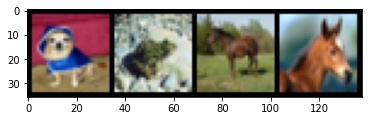

dog frog horse horse


In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

images, labels = next(iter(trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

The `transforms` module comes also in as very handy for performing other type of data transformations: here's an example which transforms the CIFAR10 images into gray scaled images.

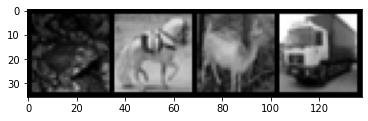

frog horse deer truck


In [7]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
gray_scaled_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
gray_scaled_trainloader = data.DataLoader(gray_scaled_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(gray_scaled_trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

### 1.1 Transforms

Al remembered from the theoretical lectures that one way to make neural networks converge faster is to **normalize** the pixel values. He wrote the following code snippet to normalize his training set, but he encountered an error.

In [8]:
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor(),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torchvision/datasets/cifar.py", line 118, in __getitem__
    img = self.transform(img)
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 94, in __call__
    img = t(img)
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 269, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/cluster/jupyter/anaconda/lib/python3.8/site-packages/torchvision/transforms/functional.py", line 358, in normalize
    raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")
TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>


Fix his mistake.

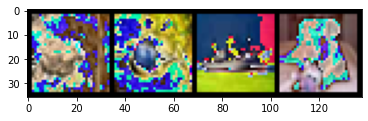

frog frog ship dog


In [9]:
# mistake was to normalize the images directly and not the tensors corresponding to the images

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

Al also remembers that, with image datasets, a common practice to increase the robustness of neural networks is **data augmentation**. He wants to apply random flips (vertical and horizontal) and random color changes to his training set, but he does not know how to. Could you help him?

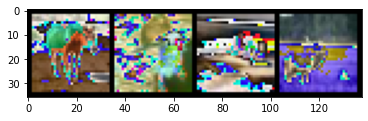

horse bird ship deer


In [10]:
#mistake was to normalize the images directly and not the tensors corresponding to the images

pHflip = 0.2
pVflip = 0.3
#pColorChange = 0.1

br_amount = 0.1
c_amount = 0.1
s_amount = 0.1
h = 0.1

transform_Hflip = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomVerticalFlip(pVflip),
    transforms.ColorJitter(brightness= br_amount, contrast=c_amount, saturation=s_amount, hue=h),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

### 1.2 Running operations on a GPU

As you may know, one important aspect of deep learning is that large models can be trained efficiently on specialized hardwares such as Graphical Processing Units (GPUs) or Tensorial Processing Units (TPUs). PyTorch allows you to perform operations on GPUs very easily by transferring the concerned models and/or tensors to GPUs.

However, to do so, you need a CUDA compatible GPU.

In [11]:
torch.cuda.is_available()

True

If the result of the previous cell is `True`, everything is ready to run on the GPU and you can continue. Otherwise it means you do not have any GPU that is compatible with the `torch` version installed on your machine. In this case, we invite you to use [Google Colab](https://colab.research.google.com/) to do the rest of this homework. Do not forget to ask Colab for a GPU (in Runtime > Change runtime type > Hardware accelerator).

In [12]:
device = 'cuda'

Let's compare the speed of tensor operations on GPU and CPU. 

In [13]:
A = torch.randn(1000, 100000)
B = torch.randn(100000, 1)

# on CPU
%timeit A @ B

32.8 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
A = torch.randn((1000, 100000), device=device)
B = torch.randn((100000, 1), device=device)

# on GPU
%timeit A @ B

The slowest run took 5.40 times longer than the fastest. This could mean that an intermediate result is being cached.
20.8 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Instead of directly creating a tensor on the GPU you may also transfer a model or a tensor on the GPU, for example we can transfer a simple MLP on the GPU and then back to the CPU as follows.

In [15]:
# create MLP on CPU
mlp = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
)

# forward pass on CPU
x = torch.randn(256, 3)
%timeit mlp(x)

# transfer MLP to GPU (in-place)
mlp.to(device)

# forward pass on GPU
x = x.to(device)
%timeit mlp(x)

# release the GPU memory
mlp.to('cpu')
x = x.to('cpu')

4.87 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
180 µs ± 877 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


As you may notice, computations are much faster on the GPU. However, data transfer between GPU and CPU (and vice-versa) is usually very slow. We recommend to reduce the transfers of data between GPU and CPU as much as possible. For example when you want to save your loss after each iteration, in order to avoid a memory leak, you should prefer doing `.detach()` rather than `.cpu()` or `.item()`.

## 2.  Classifying the CIFAR10 dataset with an MLP

Now that you know how to handle datasets, we are ready to properly train today's first deep learning model on the CIFAR10 dataset. Before we dive into it, **do not underestimate** the importance of properly pre-processing the data before training neural networks. This step is as important as defining the neural architectures themselves, but is very often overlooked.

In this exercise you are provided with an already defined multi-layer perceptron that you can train to classify CIFAR10 images. The structure of the network is already defined, yet some crucial hyperparameters are missing. It is your job to fill them in and successfully train the network. As part of the exercise, you are also required to monitor the evolution of training: this usually consists in checking how the training and testing losses evolve during training and keeping track of the model's accuracy on the testing set. Report these statistics with some plots. In addition, transfer the network and the mini-batches on GPU to speed up training.

Fill in the code below, discuss your choices and your results. Are you satisfied with the final accuracy?

In [28]:
input_features = 32**2*3   # number of input features
output_features = 10    # number of classes
hidden_features = 100
learning_rate = 0.001
num_epochs = 10

class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__(
            nn.Flatten(),
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )
    
network = MLP(input_features, output_features, hidden_features)

network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        
        for x, y in trainloader:
            x = x.to(device)
            y = y.to(device)
            
            pred = network(x)
            loss = criterion(pred, y)
            loss.to('cpu')
            train_losses.append(loss.detach())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():   
            correct = 0
            
            for x, y in testloader:
                x = x.to(device)
                y = y.to(device)
                
                pred = network(x)
                loss = criterion(pred, y)
                loss.to('cpu')
                test_losses.append(loss)
                
                y_pred = pred.argmax(dim=-1)
                correct = correct + (y_pred == y).sum()

            accuracy = correct / len(testset)

        train_avg_loss.append(torch.mean(torch.stack(train_losses)))
        test_avg_loss.append(torch.mean(torch.stack(test_losses)))
        test_accuracy.append(accuracy)

    network.to('cpu')
        
    return (train_avg_loss, test_avg_loss, test_accuracy)

In [29]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

Plot the statistics below and discuss your hyperparameter choices.

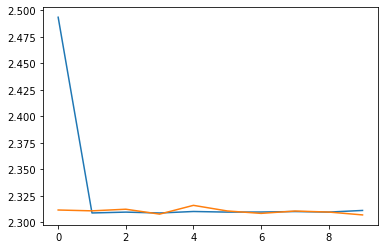

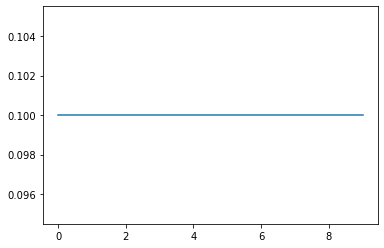

In [27]:
# your code
fig = plt.figure()
ax = plt.axes()

ax.plot(train_avg_loss)
ax.plot(test_avg_loss)
plt.show()

fig = plt.figure()
ax = plt.axes()

ax.plot(test_accuracy)
plt.show()

> your discussion

## 3.  Create a custom dataset

Sometimes you would like to train a model on your own dataset, which will very likely not be part of `torchvision`. To overcome this you can create a custom dataset class which will handle the data for you. This can be done by inheriting from `torch`'s `data.Dataset` class and defining the methods `__len__` and `__getitem__` (see the [documentation](https://pytorch.org/docs/stable/data.htm)).

In this exercise your goal is to program a custom dataset class which you will later use for training a CNN. We will use the Kaggle Cats and Dogs dataset which you can download from [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). 

When programming a custom dataset class, you have to start by defining the constructor, which will get as input the location of your dataset, whether the images that will be returned will serve for training or testing, and some other potential attributes. For this exercise we will be using 20000 images for training and 5000 images for testing. For the `__getitem__` function you may find the `PIL.Image.open` useful. Do not forget to transform the images into tensors and return the image labels as well ($0$ or $1$).

In [4]:
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

In [35]:
# your code

from tqdm import tqdm
import random
import os
from PIL import Image
classes = ('cat', 'dog')

nbTrain = 20
nbTest = 6

tr_base = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), std=(0.5,)),           # modify those values
])

class CatAndDogsDataset(data.Dataset):
    def __init__(self, root_dir, train=True, transform = tr_base):
        """Initializes a dataset containing images and labels."""
        super().__init__()
        # your code
        self.train = train                          # 
        self.root_dir = root_dir                    # path of the main directory
        self.nbList = []                            # nb of elements per category
        self.transform = transform
        if train:        
            self.count = nbTrain
            c= int(nbTrain/2)
            self.nbList = [c, c]
        else:
            self.count = nbTest
            c= int(nbTest/2)
            self.nbList = [c, c]

        self.pathList = []
        self.labelList = []
        currentClass = -1
        j = 0
        
        for animal in os.listdir(root_dir):
            if(animal == '.ipynb_checkpoints'):
                print("test")
                continue
                
            currentClass += 1
            path = os.path.join(root_dir, animal)
            pList = os.listdir(path)
            #print(pList)
            
            if self.train:
                paList = [os.path.join(path, pList[i]) for i in tqdm(range(self.nbList[j]))]
                labelList = [currentClass for i in tqdm(range(self.nbList[j]))]
            else:
                paList = []
                labelList = []
                k = 0
                while(len(paList) < self.nbList[j]):
                    if k > int(nbTrain/2):
                        paList.append(os.path.join(path, pList[k]))
                        labelList.append(currentClass)
                    k+=1

            self.pathList.extend(paList) 
            self.labelList.extend(labelList)
            
            j+=1
            

        # il faut créer les images mais comment sélectionner les 20000 images du learning set et du test set
          

    def __len__(self):
        """Returns the size of the dataset."""
        # your code
        return self.count

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        # your code
        
        image = self.transform(Image.open(self.pathList[index]))
        return image, self.labelList[index]

Let us have a quick look at these samples.

In [10]:
my_dataset = CatAndDogsDataset('kagglecatsanddogs_5340/PetImages/', train=True)
my_loader = data.DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=2)

100%|██████████| 10/10 [00:00<00:00, 44150.57it/s]

test
kagglecatsanddogs_5340/PetImages/
Dog
kagglecatsanddogs_5340/PetImages/Dog
10
56
['kagglecatsanddogs_5340/PetImages/Dog/46.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/48.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/49.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/50.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/47.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/52.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/53.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/54.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/55.jpg', 'kagglecatsanddogs_5340/PetImages/Dog/1.jpg']
kagglecatsanddogs_5340/PetImages/
Cat
kagglecatsanddogs_5340/PetImages/Cat
10
56
['kagglecatsanddogs_5340/PetImages/Cat/1.jpg', 'kagglecatsanddogs_5340/PetImages/Cat/2.jpg', 'kagglecatsanddogs_5340/PetImages/Cat/5.jpg', 'kagglecatsanddogs_5340/PetImages/Cat/4.jpg', 'kagglecatsanddogs_5340/PetImages/Cat/6.jpg', 'kagglecatsanddogs_5340/PetImages/Cat/7.jpg', 'kagglecatsanddogs_5340/PetImages/Cat/10.jpg', 'kagglecatsanddogs_5340/PetImages/Cat/8

In [11]:
images, labels = next(iter(my_loader))

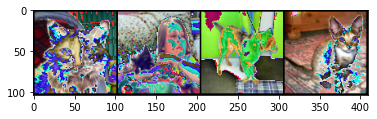

tensor(1) tensor(1) tensor(0) tensor(1)


In [12]:
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[l for l in labels])

100%|██████████| 10/10 [00:00<00:00, 7125.90it/s]


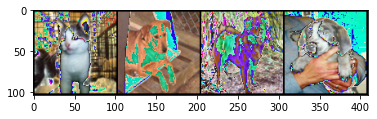

tensor(0) tensor(1) tensor(1) tensor(1)


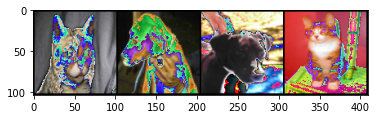

tensor(0) tensor(1) tensor(1) tensor(0)


In [46]:
my_dataset = CatAndDogsDataset('/home/mdelabrassinne/Deep/hm2/PetImages/', train=True)
my_loader = data.DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=2)
test_dataset = CatAndDogsDataset('/home/mdelabrassinne/Deep/hm2/PetImages/', train=False)
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

# your code
images, labels = next(iter(my_loader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[l for l in labels])

images, labels = next(iter(test_loader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[l for l in labels])

## 4. Classifying the Cats and Dogs dataset with a CNN

As we have seen in class, classifying images with a multi-layer perceptron isn't really a good idea. Convolutional Neural Networks (CNN) are in fact a much better option for this task. It is now your job to create your custom CNN and train it on the Cats and Dogs Dataset.

Similarly to what you have done when classifying the CIFAR10 dataset you are again required to report and discuss the performance of your model.

In [43]:
# your code

lossList = []
testLoss = []
trainAcc = []
testAcc = []

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    
    torch.nn.Flatten(),
    torch.nn.Linear(64 * 12 * 12, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    accuracy = 0
    for images, labels in my_loader:
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        predictions = outputs.argmax(dim = -1)
        accuracy += (predictions == labels).sum()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training loss after every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    lossList.append(loss.item())
    accuracy = accuracy.detach().item()
    trainAcc.append(accuracy/len(my_dataset))
    
    accuracy = 0
    for images, labels in test_loader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        testLoss.append(loss.item())
        predictions = outputs.argmax(dim=-1)
        accuracy += (predictions == labels).sum()
        
    accuracy = accuracy.detach().item()
    testAcc.append(accuracy/len(test_dataset))

Epoch [1/10], Loss: 0.7162
Epoch [2/10], Loss: 0.6646
Epoch [3/10], Loss: 0.6735
Epoch [4/10], Loss: 0.6400
Epoch [5/10], Loss: 0.4288
Epoch [6/10], Loss: 0.7794
Epoch [7/10], Loss: 0.1546
Epoch [8/10], Loss: 0.0293
Epoch [9/10], Loss: 0.0975
Epoch [10/10], Loss: 0.0893


In [44]:
print(lossList)
print(testLoss)
print(trainAcc)
print(testAcc)

[0.7162443399429321, 0.664618194103241, 0.6734637022018433, 0.6400154829025269, 0.4287864565849304, 0.7794420719146729, 0.15462495386600494, 0.029278872534632683, 0.09752899408340454, 0.08930893242359161]
[0.7467709183692932, 0.6001710891723633, 0.6955407857894897, 0.6854335069656372, 0.6934073567390442, 0.6871112585067749, 0.6339530348777771, 0.7857966423034668, 0.5799372792243958, 0.8442461490631104, 0.560715913772583, 0.60193932056427, 0.12389326095581055, 0.3015233278274536, 0.46127837896347046, 1.3454244136810303, 0.09515120834112167, 0.0085341427475214, 0.3089130222797394, 0.3538050949573517]
[0.5, 0.5, 0.5, 0.5, 0.7, 0.9, 0.95, 0.9, 0.75, 0.95]
[0.5, 0.5, 0.5, 0.5, 0.6666666666666666, 0.6666666666666666, 1.0, 0.5, 1.0, 0.6666666666666666]


> your discussion

## Feedback

Now that you are done with this final deep-learning assignment here are some final questions about the exercises you were required to solve:

<span style="color:blue">How much time did you spend on this homework?</span>

<span style="color:blue">Do you feel confortable with what it means to define a neural network and train it?</span>

<span style="color:blue">Do you think you now have enough preliminary knowledge for successfully starting to work on your course final project?</span>

<span style="color:blue">If you had to go through the two homeworks again, is there something you would have liked to explore more or explained more into detail?</span>